In [102]:
import os
import pandas as pd
import mysql.connector
from mysql.connector import errorcode
pd.options.display.float_format = '{:.4f}'.format

config = {
  'user': 'root',
  'password': '',
  'host': '127.0.0.1',
  'database': 'test',
  'raise_on_warnings': True
}

mydb = mysql.connector.connect(**config)

mycursor = mydb.cursor()

In [26]:

folder = 'F:\Backup\MyPendriveBackup'
folder_size = 0
for (path, dirs, files) in os.walk(folder):
    for file in files:
        filename = os.path.join(path, file)
        folder_size = os.path.getsize(filename)
        sql = "INSERT INTO file_size(`file_path`, `file_size`) VALUES ('%s', '%s')"%(filename.replace('\\', '\\\\'),folder_size)
#         print(sql)
#         print('Path:'+filename+'Size:'+str(folder_size))
        try:
            #Execute the SQL command
            mycursor.execute(sql)
            #Commit your changes in the database
            mydb.commit()
            print("Record "+str(index)+" inserted successfully into Laptop table")
        except:
            #Rollback in case there is any error
#             print('Error')
            mydb.rollback()

# close the connection to the database.
mydb.commit()
# print ("Folder = %0.1f MB" % (folder_size/(1024*1024.0)))

In [103]:
sql_count_folders = "SELECT file_path,file_size, \
(length(QUOTE( file_path))-length(replace(quote(file_path),'\\\\','')))/2 as no_of_folders  FROM file_size"


# print(sql_count_folders)
#Execute the SQL command
mycursor.execute(sql_count_folders)

myresult = mycursor.fetchall()

mycursor.close()
mydb.close()

df = pd.DataFrame(myresult,columns=['file_path', 'file_size', 'no_of_folders'])

In [105]:
df['location']=df['file_path'].str.rfind('\\')
df.head()

,file_path,file_size,no_of_folders,location
0,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,257847.0000,9.0000,71
1,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,873858.0000,9.0000,71
2,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,789974.0000,9.0000,70
3,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,240804.0000,9.0000,70
4,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,4828412.0000,9.0000,70


In [107]:
max_no_folders =int(df['no_of_folders'].max())

df_new=df['file_path'].str.split('\\', expand=True,n=max_no_folders)

# list(df_new.columns.values)
# df_new.columns

df_new.columns = ['Level_'+str(i) for i in range(1, max_no_folders+2)]
final_data = pd.concat([df, df_new], axis=1)
final_data.head()

,file_path,file_size,no_of_folders,location,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8,Level_9,Level_10,Level_11,Level_12
0,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,257847.0000,9.0000,71,F:,Backup,MyPendriveBackup,DD Admin,dd,assets,images,listings,directory,Pk 386.jpg,None,None
1,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,873858.0000,9.0000,71,F:,Backup,MyPendriveBackup,DD Admin,dd,assets,images,listings,directory,Reliance-Petrol-Pump2.jpg,None,None
2,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,789974.0000,9.0000,70,F:,Backup,MyPendriveBackup,DD Admin,dd,assets,images,listings,products,1.jpg,None,None
3,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,240804.0000,9.0000,70,F:,Backup,MyPendriveBackup,DD Admin,dd,assets,images,listings,products,IMG-20160529-WA0033.jpg,None,None
4,F:\Backup\MyPendriveBackup\DD Admin\dd\assets\...,4828412.0000,9.0000,70,F:,Backup,MyPendriveBackup,DD Admin,dd,assets,images,listings,products,IMG_20170224_223631125_BURST000_COVER_TOP.jpg,None,None


In [108]:
# levels = (int)
levels = final_data.no_of_folders.astype(int).unique()
# aggr_final_data ={}
aggr_final_data_new= []
level_columns_var =[]
for level in levels:
    level_columns_var.append('Level_'+str(level))
    var_name = 'Level_'+str(level)
    aggr_final_data_new.append(final_data[final_data['no_of_folders'] == float(level)]\
                               .groupby(var_name,as_index=True).agg({"file_size": "sum"}))
    

In [110]:
appended_data = pd.concat(aggr_final_data_new)
# appended_data.insert( 0, column="new",value =p, allow_duplicates=False)
appended_data.reset_index(inplace=True)
appended_data.head()

,index,file_size
0,AP_stack,20950297.0000
1,directory,1131705.0000
2,pav_krstore,361600.0000
3,products,6152633.0000
4,slider,564431.0000


In [117]:
aggr_data = appended_data.groupby('index',as_index=False).aggregate({'file_size':'sum'}) 
aggr_data['size_in_mb'] = aggr_data['file_size'].round(3)/(1024*1024)
aggr_data.head()

,index,file_size,size_in_mb
0,AP_stack,20950297.0000,19.9798
1,Deepak,55925684.0000,53.3349
2,UP Stacked Data 15Feb2017,48250462.0000,46.0152
3,USL-Mapping,71814796.0000,68.4879
4,Wipro,12513280.0000,11.9336


In [112]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

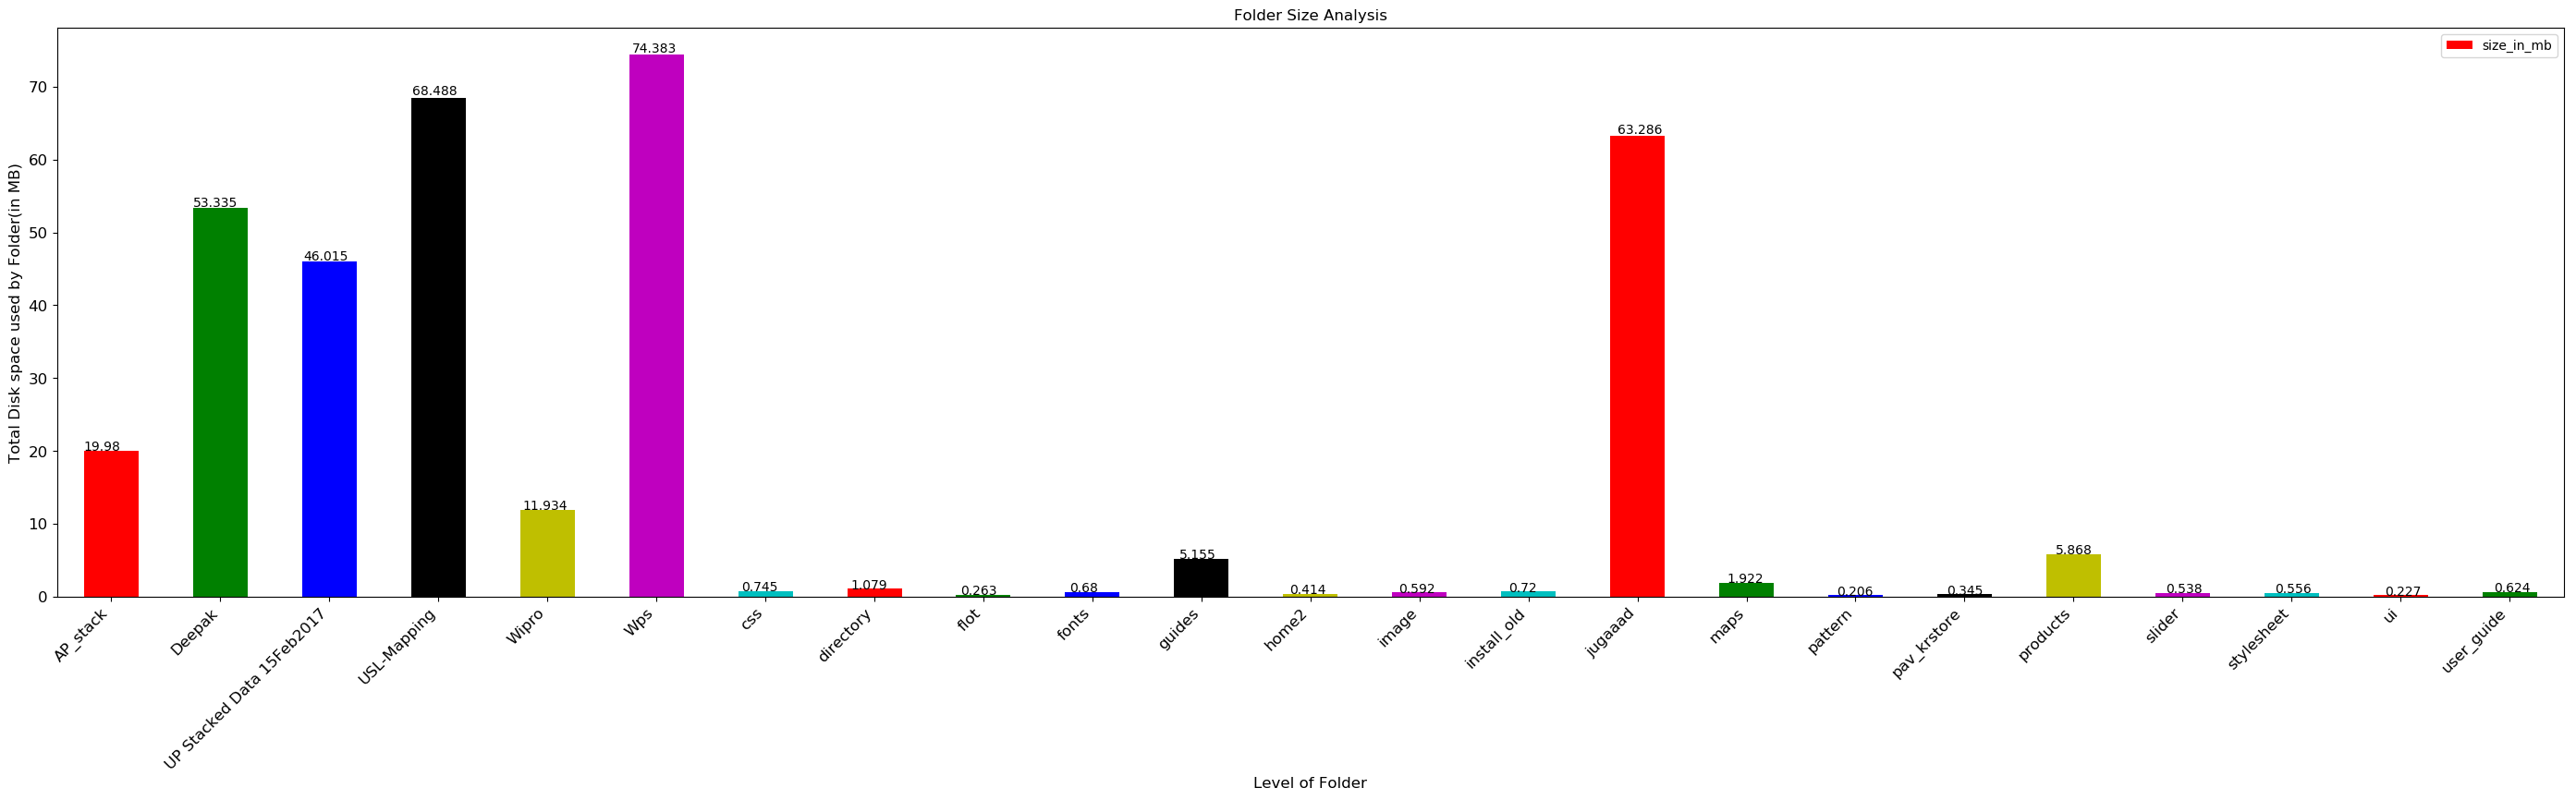

In [124]:
my_colors = 'rgbkymc'  #red, green, blue, black, etc.

ax = aggr_data[['index','size_in_mb']].round(3).set_index('index').plot.bar(rot=0, title='Folder Size Analysis', figsize=(35,8), fontsize=12, color=my_colors)
ax.set_xlabel("Level of Folder", fontsize=12)
ax.set_ylabel("Total Disk space used by Folder(in MB)", fontsize=12)
plt.xticks(rotation=45, ha="right")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.legend()
plt.show()